<a href="https://colab.research.google.com/github/Toan02Ky-UIT/ComputerVisionProject/blob/main/Resnet50_Sau_Bao_Cao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
import os
import copy
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from PIL import Image

In [3]:
ZIP_PATH = '/content/drive/MyDrive/vehicle_moi/split_data.zip'

LOCAL_DIR = '/content/temp_data'

print("1. Đang copy file ZIP từ Drive sang máy ảo")
!cp "{ZIP_PATH}" /content/

print("2. Đang giải nén (Unzip)...")

os.makedirs(LOCAL_DIR, exist_ok=True)

!unzip -q /content/split_data.zip -d "{LOCAL_DIR}"

print(f"--> HOÀN TẤT! Dữ liệu đã sẵn sàng tại {LOCAL_DIR}")

1. Đang copy file ZIP từ Drive sang máy ảo
2. Đang giải nén (Unzip)...
--> HOÀN TẤT! Dữ liệu đã sẵn sàng tại /content/temp_data


In [4]:
TRAIN_DIR = '/content/temp_data/split_data/train'
VAL_DIR   = '/content/temp_data/split_data/validation'
TEST_DIR  = '/content/temp_data/split_data/test'

In [5]:
import os

dirs_to_check = [
    ("TRAIN", TRAIN_DIR),
    ("VALIDATION", VAL_DIR),
    ("TEST", TEST_DIR)
]

for set_name, dir_path in dirs_to_check:
    print(f"--- Checking {set_name} set in: {dir_path} ---")


    total_files = 0
    try:
        classes = sorted([d for d in os.listdir(dir_path) if os.path.isdir(os.path.join(dir_path, d))])
    except Exception as e:
        print(f"Error reading directory: {e}")
        continue


    for class_name in classes:
        class_path = os.path.join(dir_path, class_name)
        files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
        count = len(files)
        print(f"  Class '{class_name}': {count} images")
        total_files += count

    print(f"TOTAL {set_name}: {total_files} images\n")

--- Checking TRAIN set in: /content/temp_data/split_data/train ---
  Class 'Auto Rickshaws': 640 images
  Class 'Bikes': 640 images
  Class 'Cars': 632 images
  Class 'Motorcycles': 640 images
  Class 'Planes': 640 images
  Class 'Ships': 640 images
  Class 'Trains': 640 images
TOTAL TRAIN: 4472 images

--- Checking VALIDATION set in: /content/temp_data/split_data/validation ---
  Class 'Auto Rickshaws': 80 images
  Class 'Bikes': 80 images
  Class 'Cars': 79 images
  Class 'Motorcycles': 80 images
  Class 'Planes': 80 images
  Class 'Ships': 80 images
  Class 'Trains': 80 images
TOTAL VALIDATION: 559 images

--- Checking TEST set in: /content/temp_data/split_data/test ---
  Class 'Auto Rickshaws': 80 images
  Class 'Bikes': 80 images
  Class 'Cars': 79 images
  Class 'Motorcycles': 80 images
  Class 'Planes': 80 images
  Class 'Ships': 80 images
  Class 'Trains': 80 images
TOTAL TEST: 559 images



In [6]:
def get_model(num_classes):
    model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

    in_f = model.fc.in_features

    model.fc = nn.Linear(in_f, num_classes)

    for param in model.parameters():
        param.requires_grad = False

    for param in model.fc.parameters():
        param.requires_grad = True

    return model

In [7]:
def train_model(model, name, train_loader, val_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=3)
    criterion = nn.CrossEntropyLoss()

    best_weights = copy.deepcopy(model.state_dict())
    best_acc = 0
    best_loss = float("inf")
    es_loss = float("inf")
    patience, stop_counter = 7, 0

    for epoch in range(200):
        model.train()
        train_loss, correct, total = 0, 0, 0

        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            out = model(imgs)
            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * imgs.size(0)
            _, preds = torch.max(out, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        train_loss /= total

        model.eval()
        correct, total, val_loss = 0, 0, 0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                out = model(imgs)
                val_loss += criterion(out, labels).item() * imgs.size(0)
                _, preds = torch.max(out, 1)
                total += labels.size(0)
                correct += (preds == labels).sum().item()

        val_acc = correct / total
        val_loss /= total
        scheduler.step(val_loss)

        print(f"{name} → Epoch {epoch+1} | train acc={train_acc:.4f} | train loss={train_loss:.4f} | "
          f"val acc={val_acc:.4f} | val loss={val_loss:.4f} | lr={optimizer.param_groups[0]['lr']:.6f}")


        if (val_acc > best_acc) or (val_acc == best_acc and val_loss < best_loss):
            best_acc = val_acc
            best_loss = val_loss
            best_weights = copy.deepcopy(model.state_dict())
            torch.save(best_weights, f"/content/drive/MyDrive/vehicle_moi/model/{name}_best.pt")
            print(" Saved best checkpoint")

        if val_loss < es_loss:
            es_loss = val_loss
            stop_counter = 0
        else:
            stop_counter += 1
            if stop_counter >= patience:
                print(" Early stopping")
                break

    model.load_state_dict(best_weights)
    return model

In [8]:
def evaluate(model, name, test_loader, class_names):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    y_true, y_pred = [], []
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs = imgs.to(device)
            out = model(imgs)
            _, preds = torch.max(out, 1)
            y_true.extend(labels.numpy())
            y_pred.extend(preds.cpu().numpy())

    print(f"\n=== {name} — Metrics ===")

    report_dict = classification_report(y_true, y_pred, target_names=class_names, digits=4, output_dict=True)

    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_true, y_pred))

    return report_dict

In [9]:
os.makedirs("/content/drive/MyDrive/vehicle_moi/model", exist_ok=True)

def fix_image(img):
    if img.mode == "P":
        img = img.convert("RGBA")
    if img.mode == "RGBA":
        img = img.convert("RGB")
    return img

batch_size = 32
img_size = 224

In [10]:
augmentations_list = []

augmentations_list.append({
    "name": "Agument_1",
    "train_tf": transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.ColorJitter(0.2, 0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225]),
    ]),
    "test_tf": transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225]),
    ])
})

augmentations_list.append({
    "name": "Agument_2",
    "train_tf": transforms.Compose([
        transforms.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    "test_tf": transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225]),
    ])
})

augmentations_list.append({
    "name": "Agument_3",
    "train_tf": transforms.Compose([
        transforms.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    "test_tf": transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225]),
    ])
})

augmentations_list.append({
    "name": "Agument_4",
    "train_tf": transforms.Compose([
        transforms.Lambda(fix_image),
        transforms.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    "test_tf": transforms.Compose([
        transforms.Lambda(fix_image),
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225]),
    ])
})

augmentations_list.append({
    "name": "Agument_5",
    "train_tf": transforms.Compose([
        transforms.Lambda(fix_image),
        transforms.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    "test_tf": transforms.Compose([
        transforms.Lambda(fix_image),
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225]),
    ])
})

In [12]:
import pandas as pd
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module="PIL")

results_data = []

for config in augmentations_list:
    name = config['name']
    print(f"\n{'='*40}\nRunning Experiment: {name}\n{'='*40}")

    current_train_tf = config['train_tf']
    current_test_tf = config['test_tf']

    train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=current_train_tf)
    val_dataset   = datasets.ImageFolder(VAL_DIR, transform=current_test_tf)
    test_dataset  = datasets.ImageFolder(TEST_DIR, transform=current_test_tf)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    num_classes = len(train_dataset.classes)
    class_names = train_dataset.classes
    print(f"Detected {num_classes} classes: {class_names}")

    model = get_model(num_classes)

    trained_model = train_model(model, name, train_loader, val_loader)

    metrics = evaluate(trained_model, name, test_loader, class_names)

    results_data.append({
        "Experiment": name,
        "Accuracy": metrics['accuracy'],
        "Macro F1": metrics['macro avg']['f1-score'],
        "Weighted F1": metrics['weighted avg']['f1-score']
    })


Running Experiment: Agument_1
Detected 7 classes: ['Auto Rickshaws', 'Bikes', 'Cars', 'Motorcycles', 'Planes', 'Ships', 'Trains']
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 179MB/s]


Agument_1 → Epoch 1 | train acc=0.8967 | train loss=0.5948 | val acc=0.9731 | val loss=0.1972 | lr=0.001000
 Saved best checkpoint
Agument_1 → Epoch 2 | train acc=0.9687 | train loss=0.1793 | val acc=0.9857 | val loss=0.1095 | lr=0.001000
 Saved best checkpoint
Agument_1 → Epoch 3 | train acc=0.9754 | train loss=0.1188 | val acc=0.9821 | val loss=0.0820 | lr=0.001000
Agument_1 → Epoch 4 | train acc=0.9801 | train loss=0.0972 | val acc=0.9821 | val loss=0.0765 | lr=0.001000
Agument_1 → Epoch 5 | train acc=0.9837 | train loss=0.0766 | val acc=0.9875 | val loss=0.0630 | lr=0.001000
 Saved best checkpoint
Agument_1 → Epoch 6 | train acc=0.9835 | train loss=0.0703 | val acc=0.9875 | val loss=0.0570 | lr=0.001000
 Saved best checkpoint
Agument_1 → Epoch 7 | train acc=0.9864 | train loss=0.0619 | val acc=0.9875 | val loss=0.0564 | lr=0.001000
 Saved best checkpoint
Agument_1 → Epoch 8 | train acc=0.9915 | train loss=0.0500 | val acc=0.9875 | val loss=0.0520 | lr=0.001000
 Saved best checkpoin

--- Evaluating Agument_4 ---
Loaded weights from /content/drive/MyDrive/vehicle_moi/model/Agument_4_best.pt

Classification Report:
                precision    recall  f1-score   support

Auto Rickshaws     1.0000    0.9875    0.9937        80
         Bikes     0.9756    1.0000    0.9877        80
          Cars     0.9873    0.9873    0.9873        79
   Motorcycles     0.9877    1.0000    0.9938        80
        Planes     1.0000    1.0000    1.0000        80
         Ships     1.0000    1.0000    1.0000        80
        Trains     1.0000    0.9750    0.9873        80

      accuracy                         0.9928       559
     macro avg     0.9929    0.9928    0.9928       559
  weighted avg     0.9930    0.9928    0.9928       559



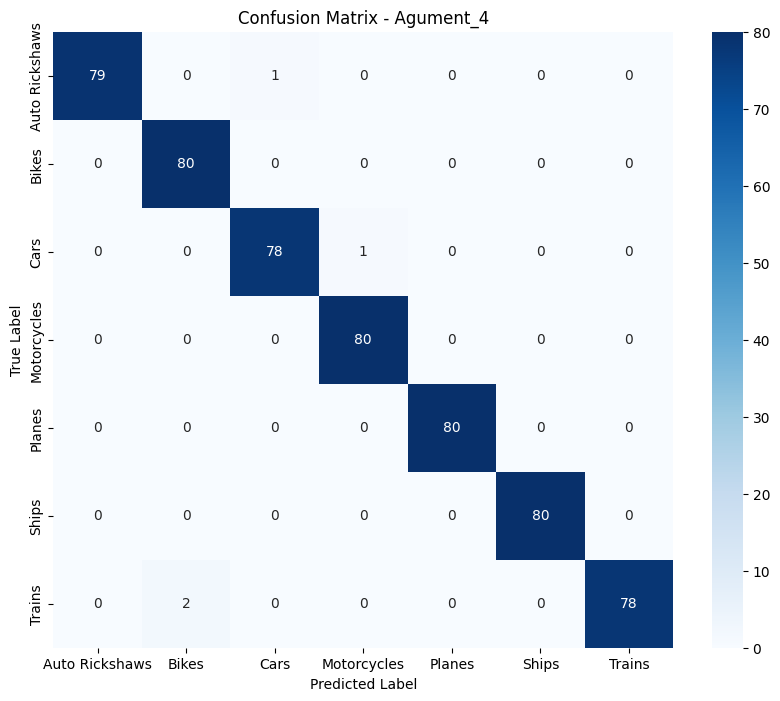


Total Correct: 555
Total Incorrect: 4


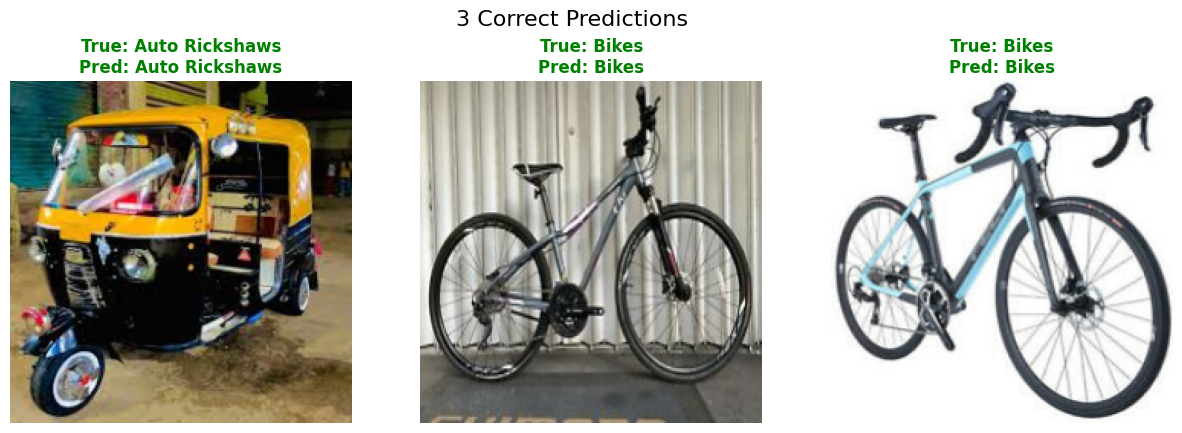

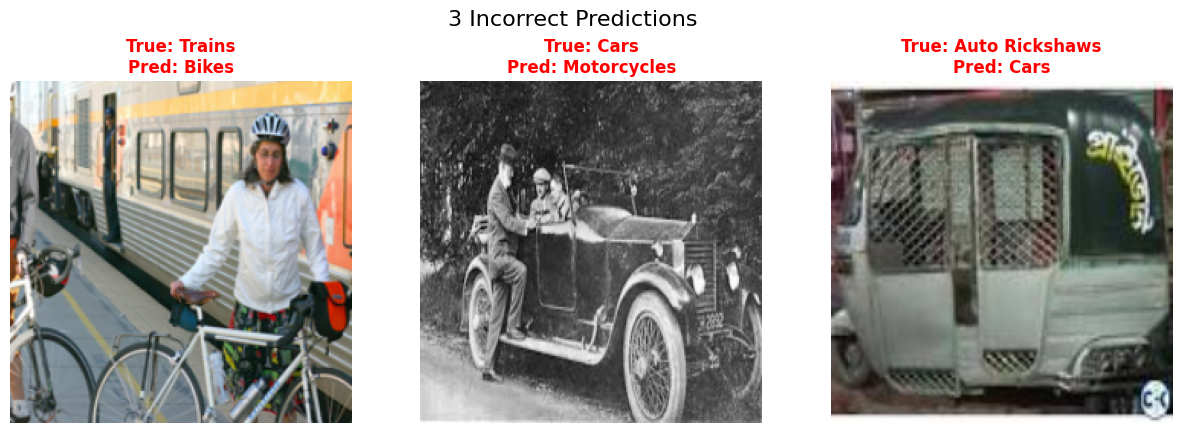

In [14]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import random

MODEL_NAME = "Agument_4"
MODEL_PATH = f"/content/drive/MyDrive/vehicle_moi/model/{MODEL_NAME}_best.pt"
config = augmentations_list[3]
test_transform = config['test_tf']

print(f"--- Evaluating {MODEL_NAME} ---")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_dataset = datasets.ImageFolder(TEST_DIR, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

num_classes = len(test_dataset.classes)
class_names = test_dataset.classes

model = get_model(num_classes)
try:
    model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
    print(f"Loaded weights from {MODEL_PATH}")
except FileNotFoundError:
    print(f"Error: Model file not found at {MODEL_PATH}")
    raise

model.to(device)
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        out = model(imgs)
        _, preds = torch.max(out, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f"Confusion Matrix - {MODEL_NAME}")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

correct_indices = [i for i, (p, l) in enumerate(zip(all_preds, all_labels)) if p == l]
incorrect_indices = [i for i, (p, l) in enumerate(zip(all_preds, all_labels)) if p != l]

def unnormalize(tensor):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = tensor.permute(1, 2, 0).numpy()
    img = img * std + mean
    return np.clip(img, 0, 1)

def show_samples(indices, title_text):
    if not indices:
        print(f"No samples found for: {title_text}")
        return

    selected = random.sample(indices, min(3, len(indices)))

    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(selected):
        img_tensor, label = test_dataset[idx]
        pred = all_preds[idx]

        plt.subplot(1, 3, i+1)
        plt.imshow(unnormalize(img_tensor))
        color = 'green' if label == pred else 'red'
        plt.title(f"True: {class_names[label]}\nPred: {class_names[pred]}", color=color, fontweight='bold')
        plt.axis('off')
    plt.suptitle(title_text, fontsize=16)
    plt.show()

print(f"\nTotal Correct: {len(correct_indices)}")
print(f"Total Incorrect: {len(incorrect_indices)}")

show_samples(correct_indices, "3 Correct Predictions")
show_samples(incorrect_indices, "3 Incorrect Predictions")